In [9]:
def generateHeader():
    header = []
    for i in range(1,26):
        header.append("y"+str(i))
        header.append("block"+str(i))
    header.append("biome")
    return header

In [17]:
import pandas as pd
import os
path = "./Data/"
headers = generateHeader()
filename_read = os.path.join(path,"data3.csv")
df = pd.read_csv(filename_read, names = headers)
pd.get_dummies(df["biome"])

,0,1,3,4,5,6,7,16,18,19,27,28,29,32,33,34,129,132,133,160
0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [19]:
import numpy as np
biomes = pd.get_dummies(df["biome"])
biomes.sum()

0        92
1      1768
3      2473
4      1265
5       150
6      1410
7       311
16      141
18     1097
19       26
27      619
28       25
29      118
32      211
33       42
34     1083
129     110
132      16
133      24
160      44
dtype: int64

In [20]:
import matplotlib.pyplot as plt
plt.figure()

<Figure size 640x480 with 0 Axes>

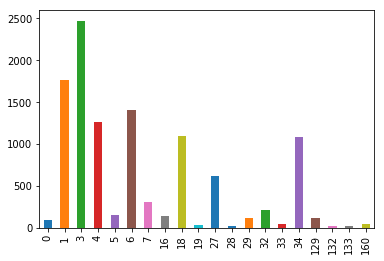

In [21]:
biomes.sum().plot(kind='bar')

In [22]:
df = df[df.biome!=0]
df = df[df.biome!=5]
df = df[df.biome!=7]
df = df[df.biome!=16]
df = df[df.biome!=19]
df = df[df.biome!=28]
df = df[df.biome!=29]
df = df[df.biome!=32]
df = df[df.biome!=33]
df = df[df.biome!=129]
df = df[df.biome!=132]
df = df[df.biome!=133]
df = df[df.biome!=160]


In [30]:
df = df[df.biome!=3]
df = df[df.biome!=27]
biomes = pd.get_dummies(df["biome"])
biomes.sum()

1     1768
4     1265
6     1410
18    1097
34    1083
dtype: int64

In [31]:
biomes.shape

(6623, 5)

In [32]:
biomes.std()

1     0.442399
4     0.393120
6     0.409385
18    0.371781
34    0.369868
dtype: float64

In [33]:
path = './Data/'
filename_write = os.path.join(path, 'data_cleaned2.csv')
df.to_csv(filename_write, index = False)